In [15]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from tqdm import tqdm
import os, sys
import SimpleITK as sitk
import cv2
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def register_test(INPUT, fixed_index, moving_index):
    pixelType = sitk.sitkFloat32
    fixed_file = os.path.join(INPUT, f'{fixed_index}.tif')
    moving_file = os.path.join(INPUT, f'{moving_index}.tif')
    fixed = sitk.ReadImage(fixed_file, pixelType);
    moving = sitk.ReadImage(moving_file, pixelType)

    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving,
        sitk.Euler2DTransform(),
        sitk.CenteredTransformInitializerFilter.MOMENTS)

    R = sitk.ImageRegistrationMethod()
    R.SetInitialTransform(initial_transform, inPlace=True)
    #R.SetMetricAsCorrelation() # -0439
    #R.SetMetricAsMeanSquares()
    R.SetMetricAsMattesMutualInformation()
    R.SetMetricSamplingStrategy(R.REGULAR) # random = 0.442 # regular -0.439
    R.SetMetricSamplingPercentage(0.8)
    R.SetInterpolator(sitk.sitkLinear)
    # Optimizer settings.
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=1,
                                               minStep=1e-4,
                                               numberOfIterations=100,
                                               gradientMagnitudeTolerance=1e-8)
    R.SetOptimizerScalesFromPhysicalShift()

    # Connect all of the observers so that we can perform plotting during registration.
    R.AddCommand(sitk.sitkStartEvent, start_plot)
    R.AddCommand(sitk.sitkEndEvent, end_plot)
    R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
    R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))


    final_transform = R.Execute(sitk.Cast(fixed, sitk.sitkFloat32),
                                                   sitk.Cast(moving, sitk.sitkFloat32))

    return final_transform, fixed, moving, R


In [6]:
animal = 'DK37'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')

In [50]:
fixed_index = str(1).zfill(3)
moving_index = str(2).zfill(3)

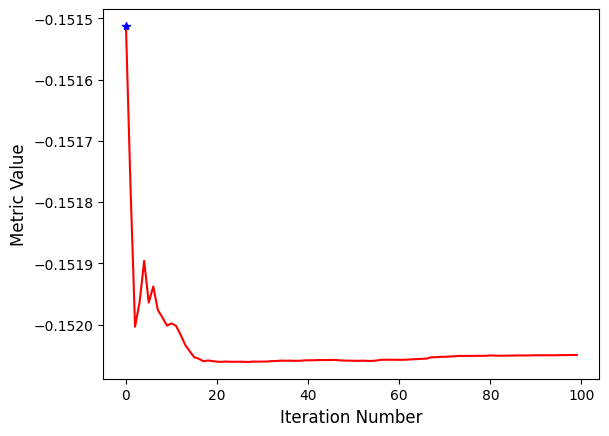

Final metric value: -0.15204965988220798
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (100) exceeded.
final (-0.0016186655916414383, -0.9578535066950284, -3.4370185465334235)
fixed (898.1218079349231, 527.8963319177986)


In [51]:
final_transform, fixed, moving, R = register_test(INPUT, fixed_index, moving_index)
testParameters = final_transform.GetParameters()
testFixedParameters = final_transform.GetFixedParameters()
# Always check the reason optimization terminated.
stop_condition = R.GetOptimizerStopConditionDescription()
iterations = R.GetOptimizerIteration()
metric_value = R.GetMetricValue()

print(f'Final metric value: {metric_value}')
print(f'Optimizer\'s stopping condition, {stop_condition}')
print('final', testParameters)
print('fixed', testFixedParameters)

In [52]:
%%time
pixelType = sitk.sitkFloat32
fixed_file = os.path.join(INPUT, f'{fixed_index}.tif')
moving_file = os.path.join(INPUT, f'{moving_index}.tif')
fixed = sitk.ReadImage(fixed_file, pixelType)
moving = sitk.ReadImage(moving_file, pixelType)

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed)
elastixImageFilter.SetMovingImage(moving)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("translation"))
elastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap("rigid"))
elastixImageFilter.Execute()
trans_params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
rigid_params = elastixImageFilter.GetTransformParameterMap()[1]["TransformParameters"]
x1,y1 = trans_params
R,x2,y2 = rigid_params
R = float(R)
x = float(x1) + float(x2)
y = float(y1) + float(y2)



Time spent on saving the results, applying the final transform etc.: 128 ms.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [0, 0]
Initialization of all components (before registration) took: 0 ms.
Preparation of the image pyramids took: 105 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting th

106	-0.183356	6.004681	82.017813	0.001307	0.6
107	-0.222746	6.622274	80.184018	0.002246	0.7
108	-0.217467	5.753068	82.789194	0.000539	0.6
109	-0.193392	4.900949	85.512887	0.001297	0.8
110	-0.184631	4.136502	88.113489	0.000890	0.7
111	-0.226219	3.275855	91.237360	0.001468	0.7
112	-0.205482	2.426064	94.547035	0.001793	0.6
113	-0.197593	2.846458	92.880247	0.000992	0.6
114	-0.160405	3.844917	89.147608	0.000824	0.6
115	-0.240488	4.793846	85.867960	0.001375	0.6
116	-0.159172	5.776228	82.717586	0.001127	0.7
117	-0.204134	5.065194	84.974043	0.000660	0.7
118	-0.198155	5.990925	82.059616	0.001765	0.6
119	-0.191599	5.768195	82.742407	0.000533	0.6
120	-0.169692	6.286484	81.170770	0.000113	0.6
121	-0.197047	6.216318	81.380035	0.002532	0.7
122	-0.191342	6.362335	80.945757	0.002310	0.7
123	-0.217009	5.493127	83.601491	0.001793	0.7
124	-0.189512	4.623920	86.437397	0.002441	0.8
125	-0.197109	3.754712	89.472457	0.001762	0.8
126	-0.168527	4.749169	86.016948	0.001296	0.7
127	-0.204782	5.735320	82.844151	0

125	-0.170649	15.686572	58.960178	0.004309	0.6
126	-0.162298	14.920193	60.218130	0.000734	0.8
127	-0.180711	15.919880	58.587591	0.001799	0.7
128	-0.209842	15.187623	59.773112	0.001746	0.8
129	-0.183134	14.422797	61.063693	0.000720	0.8
130	-0.210418	13.817497	62.125282	0.001768	0.7
131	-0.186869	14.685159	60.614746	0.002473	0.6
132	-0.173538	15.685023	58.962668	0.000953	0.7
133	-0.193469	15.211274	59.734071	0.001702	0.7
134	-0.220656	16.133186	58.251043	0.000874	0.6
135	-0.203228	15.387346	59.445029	0.005193	0.6
136	-0.158626	16.385567	57.857805	0.000392	0.6
137	-0.182908	15.650642	59.017979	0.001753	0.6
138	-0.169358	15.333137	59.533720	0.000899	0.6
139	-0.211628	14.590603	60.775785	0.004768	0.6
140	-0.161991	13.824266	62.113206	0.001758	0.6
141	-0.193838	13.057901	63.510866	0.001456	0.6
142	-0.178072	13.443590	62.799691	0.002657	0.7
143	-0.177167	12.686535	64.211021	0.002824	0.6
144	-0.175819	13.686535	62.359841	0.004419	0.6
145	-0.191548	12.920156	63.768776	0.001469	0.7
146	-0.206577

141	-0.169358	15.965034	22.970034	0.002457	0.6
142	-0.198193	15.167604	23.476481	0.006164	0.7
143	-0.201421	14.366081	24.008543	0.005473	0.7
144	-0.173539	15.366081	23.348352	0.005160	1.2
145	-0.203012	16.318596	22.752412	0.003579	0.9
146	-0.166011	17.278396	22.181913	0.003244	0.9
147	-0.190926	16.541287	22.617447	0.001329	0.8
148	-0.145151	17.306855	22.165434	0.007115	0.7
149	-0.175308	16.519951	22.630309	0.000631	0.7
150	-0.171475	17.298021	22.170547	0.002695	0.7
151	-0.172078	17.160045	22.250709	0.004559	0.7
152	-0.202462	18.154181	21.685757	0.003082	0.8
153	-0.170697	17.352725	22.138924	0.003791	0.7
154	-0.169051	16.855605	22.429653	0.004797	0.7
155	-0.192273	17.855312	21.852561	0.004876	0.6
156	-0.165129	17.053226	22.313169	0.002832	0.6
157	-0.153308	18.050051	21.743584	0.001837	0.6
158	-0.170559	18.336176	21.585425	0.004075	0.7
159	-0.197701	19.210173	21.116250	0.001304	0.6
160	-0.182842	18.796836	21.335567	0.001972	0.6
161	-0.160273	18.433012	21.532418	0.004088	0.6
162	-0.187117

163	-0.195609	39.517226	10.407694	0.007118	0.8
164	-0.173468	40.433539	10.252458	0.020699	0.7
165	-0.187668	41.431862	10.088515	0.010132	0.8
166	-0.200240	40.893064	10.176339	0.008083	1.1
167	-0.169142	41.893056	10.014536	0.016254	0.8
168	-0.210060	42.893056	9.857797	0.010089	0.7
169	-0.175872	42.354257	9.941633	0.013499	0.6
170	-0.200582	41.815459	10.026907	0.010482	0.6
171	-0.185160	42.815458	9.869784	0.006742	0.6
172	-0.183921	42.276670	9.953823	0.006090	0.6
173	-0.176090	41.741393	10.038744	0.007489	0.7
174	-0.182314	41.203714	10.125517	0.008612	0.7
175	-0.182839	40.666772	10.213682	0.011195	0.6
176	-0.216907	40.127984	10.303706	0.006576	0.7
177	-0.151890	39.589189	10.395333	0.008312	0.6
178	-0.166075	40.585230	10.227205	0.010040	0.6
179	-0.205176	40.046457	10.317467	0.010811	0.6
180	-0.163949	41.046453	10.151181	0.010750	0.6
181	-0.198571	42.046453	9.990170	0.005738	0.6
182	-0.194797	41.507739	10.076269	0.004146	0.6
183	-0.177304	41.164443	10.131914	0.004441	0.6
184	-0.151134	42.0

105	-0.189460	7.461085	44.324738	0.000574	0.7
106	-0.170452	8.018237	43.473699	0.001578	0.9
107	-0.178609	7.202474	44.731185	0.000976	0.9
108	-0.186449	6.274656	46.252833	0.000678	0.8
109	-0.197222	6.740203	45.476600	0.000471	0.8
110	-0.166135	6.281771	46.240770	0.000398	0.7
111	-0.181038	6.569772	45.757727	0.001722	0.7
112	-0.222233	7.361843	44.479835	0.001305	0.7
113	-0.217191	8.361779	42.965043	0.002132	0.7
114	-0.189456	7.431608	44.370692	0.001610	0.8
115	-0.181858	6.501129	45.871939	0.001902	0.7
116	-0.221488	5.570649	47.478332	0.001444	0.7
117	-0.204652	4.640179	49.201299	0.002000	0.7
118	-0.194980	4.313995	49.835283	0.001923	0.7
119	-0.162015	5.313995	47.941414	0.000966	0.7
120	-0.236564	6.313978	46.186245	0.003353	0.7
121	-0.155532	7.313978	44.555028	0.001550	0.7
122	-0.203253	6.383499	46.068989	0.001822	0.7
123	-0.194914	5.453025	47.689446	0.000875	0.7
124	-0.190767	6.435688	45.981354	0.001648	0.7
125	-0.168412	5.580617	47.460527	0.001239	0.7
126	-0.198816	4.651560	49.179469	0

109	-0.179491	17.262482	35.864243	0.001008	2.1
110	-0.187275	16.881662	36.224782	0.000880	0.9
111	-0.152518	17.647457	35.506992	0.001229	0.7
112	-0.180110	17.133983	35.985094	0.001266	1.3
113	-0.175114	16.477549	36.615387	0.001552	0.8
114	-0.174787	15.720431	37.370339	0.000087	0.8
115	-0.219261	15.826582	37.262621	0.000618	0.7
116	-0.195139	15.770547	37.319405	0.002242	0.7
117	-0.179194	15.999731	37.088241	0.003536	0.7
118	-0.186454	16.999731	36.112228	0.002686	0.8
119	-0.176296	16.226828	36.861990	0.000819	0.7
120	-0.197788	15.484530	37.611967	0.002771	0.7
121	-0.197720	14.821764	38.307856	0.001468	0.7
122	-0.176231	14.048902	39.152580	0.003725	0.7
123	-0.203320	15.048698	38.066700	0.001028	0.8
124	-0.177301	16.044386	37.043534	0.001765	0.7
125	-0.147910	15.586742	37.506891	0.001244	0.7
126	-0.196014	16.576808	36.518667	0.003724	0.7
127	-0.206001	17.576789	35.572037	0.001654	0.7
128	-0.193166	18.576715	34.673291	0.003144	0.8
129	-0.202537	17.803830	35.363905	0.000922	0.8
130	-0.187867

69	-0.166581	0.620818	32.675437	0.000795	0.7
70	-0.184488	0.233262	33.271840	0.003192	2.2
71	-0.204948	0.545717	32.789332	0.005732	1.4
72	-0.196220	0.000000	33.641413	0.004642	1.3
73	-0.172785	0.000000	33.641413	0.001938	1.0
74	-0.207721	0.000000	33.641413	0.003007	0.9
75	-0.191601	0.000000	33.641413	0.002673	0.8
76	-0.197023	0.000000	33.641413	0.002207	0.8
77	-0.197109	0.603268	32.701983	0.002152	0.8
78	-0.178080	0.249761	33.246006	0.001562	0.9
79	-0.169359	0.000000	33.641413	0.004000	0.9
80	-0.171139	0.573387	32.747277	0.003393	0.8
81	-0.176142	1.565265	31.307839	0.002162	0.8
82	-0.172306	2.205197	30.444459	0.003288	0.8
83	-0.195652	1.533908	31.351405	0.004621	0.8
84	-0.128231	2.520304	30.036588	0.002081	0.9
85	-0.151025	1.828053	30.947435	0.002711	0.8
86	-0.175215	1.182357	31.848269	0.007409	0.7
87	-0.176661	0.484794	32.882311	0.005643	0.8
88	-0.181608	0.000000	33.641413	0.005508	0.8
89	-0.177765	1.000000	32.112258	0.005136	0.7
90	-0.165946	0.301057	33.165945	0.005075	0.7
91	-0.1741

50	-0.171411	5.797280	13.113754	0.009677	0.6
51	-0.159603	5.179186	13.423372	0.006682	0.8
52	-0.175251	5.007901	13.511777	0.001945	0.9
53	-0.185086	5.001388	13.515161	0.015474	0.9
54	-0.168098	5.220651	13.402145	0.009720	0.7
55	-0.197151	6.219802	12.910195	0.004719	0.7
56	-0.160323	6.466440	12.794266	0.005028	0.7
57	-0.158161	7.265689	12.432492	0.008502	0.6
58	-0.167758	6.666960	12.701538	0.006256	0.7
59	-0.156831	7.023328	12.540015	0.010407	0.7
60	-0.161753	8.020433	12.109156	0.006212	0.7
61	-0.139856	7.403031	12.372375	0.004081	0.7
62	-0.161322	7.847861	12.181595	0.004099	0.6
63	-0.174826	7.374215	12.384940	0.011614	0.7
64	-0.186514	7.638801	12.270519	0.007758	0.7
65	-0.174446	8.638640	11.856582	0.009655	0.7
66	-0.201260	8.020759	12.109020	0.004070	0.7
67	-0.175812	7.464920	12.345475	0.008674	0.7
68	-0.188015	6.871605	12.608278	0.009237	0.7
69	-0.185510	7.273982	12.428845	0.004001	0.7
70	-0.174410	8.205077	12.032598	0.009480	0.7
71	-0.161280	9.169027	11.648137	0.011074	0.7
72	-0.1695


Final metric value  = -0.168806
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 1261.530111 1372.254953 706.469680 351.412954 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.930480 -0.772904 -0.698945 -0.618158 )
( SigmoidScale 0.000000 0.000000 0.000002 0.000008 )

CPU times: user 8.56 s, sys: 531 ms, total: 9.09 s
Wall time: 2.12 s


In [48]:
dimension = 2        
offset = [2]*dimension # use a Python trick to create the offset list based on the dimension
translation = sitk.TranslationTransform(dimension, offset)
print(translation)

itk::simple::Transform
 TranslationTransform (0x55feb7bac3d0)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 1
   Modified Time: 10884359
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [2, 2]



In [53]:
R,x,y

(-0.000721262, -1.474537, -2.5600519999999998)

In [58]:
point = [10, 11]
rotation2D = sitk.Euler2DTransform()
rotation2D.SetTranslation((x,y))
rotation2D.SetAngle(R)
print(f'original point: {point}')
transformed_point = rotation2D.TransformPoint(point)
translation_inverse = rotation2D.GetInverse()
print(f'transformed point: {transformed_point}')
print(f'back to original: {translation_inverse.TransformPoint(transformed_point)}')

original point: [10, 11]
transformed point: (8.533394280217857, 8.43273251942168)
back to original: (10.0, 11.0)


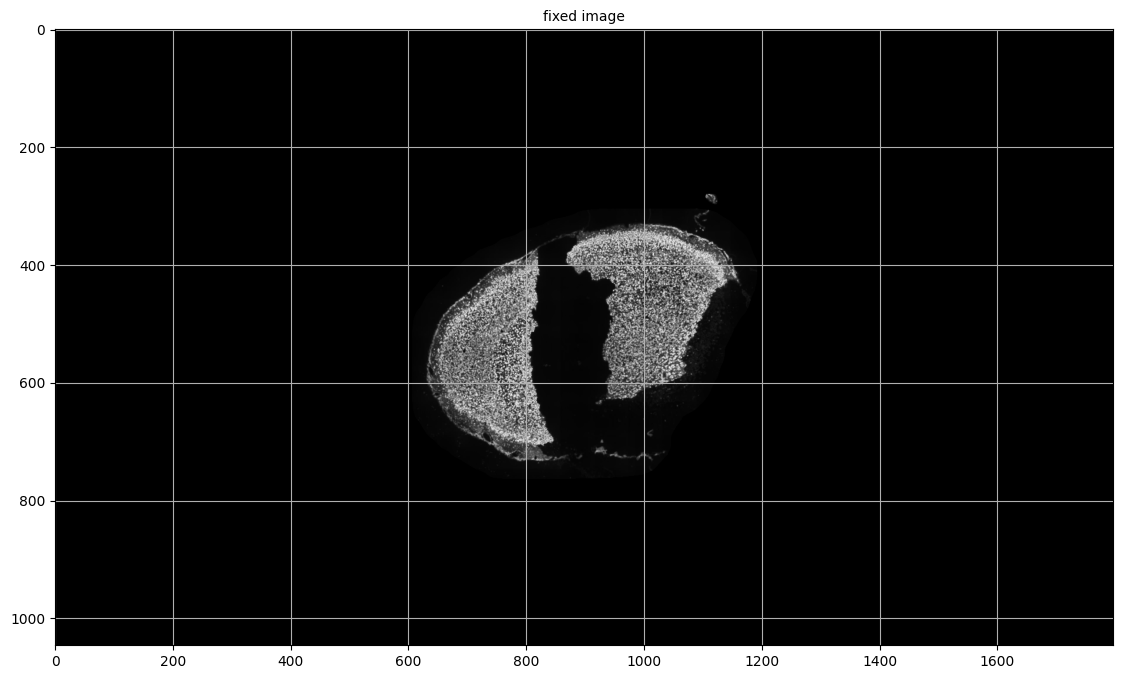

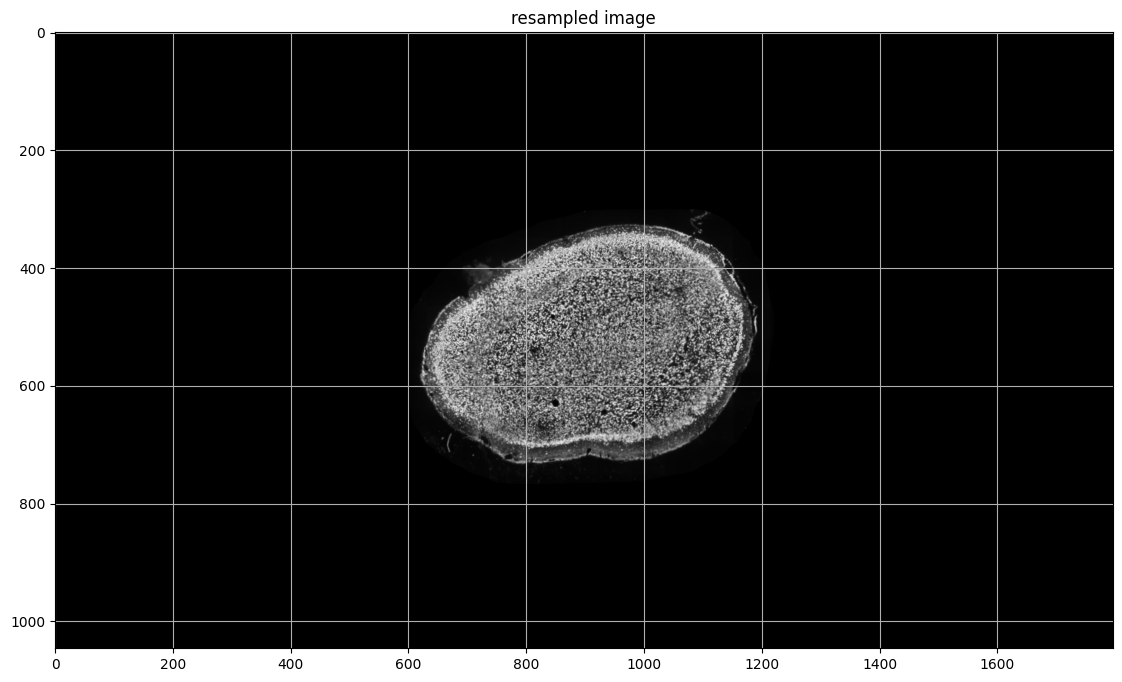

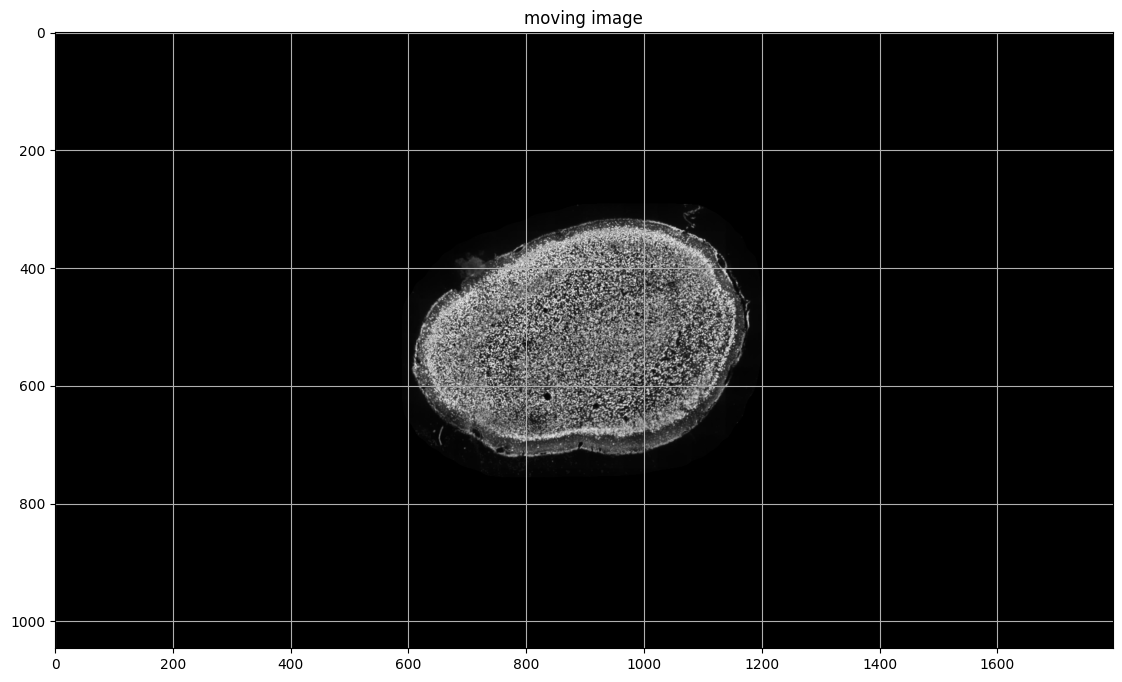

In [40]:
moving_resampled = sitk.Resample(moving, fixed, final_transform, sitk.sitkLinear, 0.0, moving.GetPixelID())
fig = plt.figure(figsize=(15,8))
plt.imshow(sitk.GetArrayViewFromImage(fixed), cmap='gray')
plt.grid()
plt.title('fixed image', fontsize=10)

fig = plt.figure(figsize=(15, 8))
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled), cmap='gray')
plt.grid()
plt.title('resampled image')

fig = plt.figure(figsize=(15, 8))
plt.title('moving image')
plt.grid()
plt.imshow(sitk.GetArrayViewFromImage(moving), cmap='gray')
    